In [1]:
import pandas as pd
from pvops.text.preprocess import text_remove_numbers_stopwords
from nltk import corpus
from nltk.tokenize import word_tokenize
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

stopwords = corpus.stopwords.words('english')

Read in the asset-related inverter records. Make a combined `'FullDesc'` column that contains all the text data associated with that record.

In [2]:
OM_df = pd.read_csv('inverter_OM_records.csv')
OM_df['FullDesc'] = OM_df['GeneralDesc'].astype(str) + '; ' + OM_df['CompletionDesc'].astype(str)

Drop the rows that don't have all the data we need. Also, only interested in the CM (corrective maintenance) records.

In [3]:
OM_nonnull_df = OM_df.dropna(subset=['Date_EventStart_Consistent', 'randid', 'states', 'Commissioning_Date', 'WOType'])
OM_nonnull_df = OM_nonnull_df[OM_nonnull_df['WOType'].str.contains('Corrective')]

Define a function to tokenize the text fields

In [4]:
def prep_documents(documents, lower_thresh=0, verbose=True):
    # Create a dictionary representation of the documents
    dictionary = corpora.Dictionary(documents)
    
    # Filter out tokens that appear in less than `lower_thresh` documents
    if lower_thresh > 0:
        dictionary.filter_extremes(no_below=lower_thresh)
    
    # Convert documents to bag-of-words format
    corpus = [dictionary.doc2bow(doc) for doc in documents]
    
    if verbose:
        print(f"Number of unique tokens: {len(dictionary)}")
        print(f"Number of documents: {len(corpus)}")
    
    return corpus, dictionary

Clean up the description by shifting to lowercase, removing stopwords, tokenizing, and finally using the function above

In [5]:
# Process the documents
OM_nonnull_df['FullDescCleaned'] = OM_nonnull_df['FullDesc'].str.lower()
OM_nonnull_df['FullDescCleaned'] = OM_nonnull_df.apply(lambda x : text_remove_numbers_stopwords(x['FullDescCleaned'],
                                                                                                stopwords + ['nan']), axis='columns')
OM_nonnull_df['FullDescTokenized'] = [word_tokenize(desc) for desc in (OM_nonnull_df['FullDescCleaned'])]
my_corpus, dictionary = prep_documents(OM_nonnull_df['FullDescTokenized'])

Number of unique tokens: 8486
Number of documents: 15411


Define function to get the coherence values

In [6]:
def compute_coherence_values(dictionary, corpus, documents, start, limit, step, random_state=42):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, random_state=random_state)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=documents, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [7]:
# Compute coherence values for different numbers of topics
start, limit, step = 2, 101, 1
model_list, coherence_values = compute_coherence_values(dictionary, my_corpus, OM_nonnull_df['FullDescTokenized'],
                                                        start, limit, step)

# Print the coherence values
for m, cv in zip(range(start, limit, step), coherence_values):
    print(f"Num Topics = {m}, Coherence Value = {cv:.4f}")

  0%|          | 0/99 [00:00<?, ?it/s]

Num Topics = 2, Coherence Value = 0.4465
Num Topics = 3, Coherence Value = 0.4404
Num Topics = 4, Coherence Value = 0.4056
Num Topics = 5, Coherence Value = 0.4171
Num Topics = 6, Coherence Value = 0.4117
Num Topics = 7, Coherence Value = 0.3899
Num Topics = 8, Coherence Value = 0.3993
Num Topics = 9, Coherence Value = 0.3880
Num Topics = 10, Coherence Value = 0.3398
Num Topics = 11, Coherence Value = 0.3592
Num Topics = 12, Coherence Value = 0.3630
Num Topics = 13, Coherence Value = 0.3555
Num Topics = 14, Coherence Value = 0.3298
Num Topics = 15, Coherence Value = 0.3328
Num Topics = 16, Coherence Value = 0.3290
Num Topics = 17, Coherence Value = 0.3326
Num Topics = 18, Coherence Value = 0.3298
Num Topics = 19, Coherence Value = 0.3340
Num Topics = 20, Coherence Value = 0.3267
Num Topics = 21, Coherence Value = 0.3166
Num Topics = 22, Coherence Value = 0.3262
Num Topics = 23, Coherence Value = 0.3326
Num Topics = 24, Coherence Value = 0.3287
Num Topics = 25, Coherence Value = 0.3261


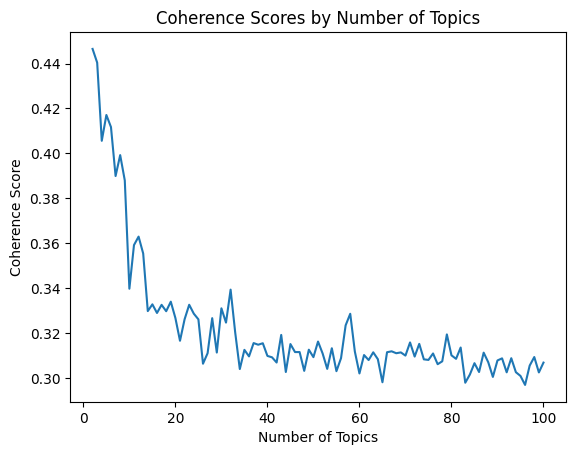

In [9]:
# Plot coherence values
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Scores by Number of Topics")
plt.show()

In [17]:
radius = 15
for i, (k, coherence) in enumerate(zip(range(start, limit, step), coherence_values)):
    range_min = max(0, i-radius)
    range_max = min(len(coherence_values)-1, i+radius)
    if coherence == max(coherence_values[range_min : range_max+1]):
        print(k, coherence)

2 0.44651479609677003
32 0.33936627299426525
58 0.3286207253464865
79 0.31944181289181334


32, 58, or 79 seem like good picks for the number of topics to use